# **1. Mô tả ứng dụng** 

## **Ứng dụng mà nhóm chọn**
Huấn luyện Convolutional Neural Network để phân lớp ảnh bằng Stochastic Gradient Descent.
*   **Input:** Tập dữ liệu ảnh và nhãn của ảnh, cấu trúc của CNN và các tham số liên quan.

*   **Output:** Mô hình phân lớp ảnh sau khi huấn luyện.

*   **Ý nghĩa của ứng dụng trong thực tế:** Giúp số hoá tài liệu, OCR...

## **Ứng dụng này có cần phải tăng tốc không**
Có, vì tập dữ liệu lớn và có nhiều hidden layer nên chạy rất chậm nếu chạy tuần tự.

## **Ứng dụng này có thể tăng tốc bằng cách song song hóa không**
Có, vì trong đó có phép convolution, phép nhân ma trận, phép max-pooling,...

# **2. Cài đặt tuần tự**

## **Thiết kế**

*   Trộn ngẫu nhiên thứ tự ảnh.

*   Đối với mỗi bức ảnh đầu vào, ta sẽ chuyển nó về mảng numpy.

*   Nếu là ảnh RGB thì ta sẽ chuyển nó về ảnh grayscale.

*   Tập ảnh sẽ được chia thành nhiều batch có kích thước giống nhau và lớn hơn hoặc bằng 1, batch cuối cùng có thể có kích thước khác.

*   Với mỗi batch được đưa vào, ta sẽ chuẩn hoá các mảng numpy trong batch về khoảng [-0.5,0.5] để tránh việc giá trị các lớp sau trở nên quá lớn.

*   CNN sẽ có 1 tầng convolutional, 1 tầng max-pooling, 1 tầng fully connected và activation là hàm softmax.

    *   Tầng convolution dùng để nhận dạng các đặc trưng cụ thể hoặc hình mẫu trong bức ảnh.

    *   Tầng max-pooling dùng để tập hợp các đặc trưng nhỏ lẻ của ảnh thành một đặc trưng lớn hơn, ít nhạy cảm với vị trí của đặc trưng hơn.

    *   Tầng fully connected dùng để quyết định nhãn của ảnh.

    ![](https://victorzhou.com/media/cnn-post/cnn-dims-3.svg)

    <center><small>Nguồn: https://victorzhou.com/blog/intro-to-cnns-part-1/</small></center>

*   **Lan truyền xuôi:**

    *   ***Tầng convolution:***

        Trong tầng này, ta sẽ có $n$ node tương đương với $n$ filter với kích thước là $m$x$m$, trọng số của các filter này sẽ được khởi tạo ngẫu nhiên và mỗi trọng số đó sẽ được chia cho $m$x$m$ để chống việc kết quả ra số quá lớn.

        Ta sẽ lần lượt trượt các filter từ phải sang trái, từ trên xuống dưới, mỗi lần một pixel. Với mỗi pixel tương ứng trong cửa sổ trượt, ta sẽ nhân giá trị của nó với trọng số trong filter rồi cộng lại với nhau.

        ![](https://drive.google.com/uc?export=view&id=1riGOZlVlZdE-iAId6b23kaMLz7NncRT-)

        ![](https://drive.google.com/uc?export=view&id=1M7zZWBg4Hr_aJ7OJZ1t_Y4s48DuYUSkq)

    *   ***Tầng max-pooling:***

        Với pool có kích thước là $p$x$p$, ta cũng lần lượt trượt các filter từ phải sang trái, từ trên xuống dưới, nhưng mỗi lần là $p$ pixel. Ta sẽ chọn ra giá trị lớn nhất trong cửa sổ trượt đó.

        ![](https://drive.google.com/uc?export=view&id=1soCPEqlOsBjZNTap4opnfFF5rehv0anc)

    *   ***Tầng fully connected:***

        Ta sẽ có $k$ node tương đương với $k$ lớp cần phân, vì đây là tầng fully connected nên tất cả các node của tầng trước sẽ được nối với tất cả các node trong tầng này. Tức là giá trị đầu ra của mỗi node sẽ được tính bằng công thức sau: $t = w * x + b$ với $t$ là giá trị đầu ra của mỗi node, $w$ là vector chứa trọng số của node đó, $x$ là vector các giá trị đầu ra của tất cả các node ở tầng trước đó và $b$ là bias của node đó. Với $k$ node ta sẽ thu được một vector $k$ chiều và ta sẽ tính softmax của vector này, mỗi giá trị sẽ tương ứng với xác suất của mỗi lớp và ta sẽ chọn lớp nào có xác suất cao nhất.

        Ta sẽ dùng độ đo cross-entropy để tính độ lỗi: $L=-\text{ln}(p_c)$ với $p_c$ là xác suất của lớp đúng $c$.

*   **Lan truyền ngược:**

    Mục tiêu của việc học chỉ đơn giản là tối thiểu hoá độ lỗi. Để làm được điều đó, ta sẽ sử dụng kĩ thuật là Gradient Descent (GD), tức là ta phải tính gradient của hàm lỗi. Ở đây ta sẽ sử dụng một biến thể của GD là Stochastic Gradient Descent (SGD).
    SGD cũng giống như GD nhưng thay vì cập nhật các trọng số và bias sau khi duyệt hết tập train, ta sẽ cập nhật với mỗi một batch được duyệt.

    Trong quá trình này ta sẽ lần lượt tính các gradient của từng tầng bằng quy tắt mắc xích để cập nhật các trọng số và bias trong các tầng đó.

    *   ***Tầng fully connected:***

        Ta có thể dùng quy tắc mắc xích để tính các gradient sau của mỗi bức ảnh:
        \begin{equation}
          \frac{\partial L}{\partial w} = \frac{\partial L}{\partial {\text{output}_\text{FCL}}} * \frac{\partial {\text{output}_\text{FCL}}}{\partial t} * \frac{\partial t}{\partial w}
        \end{equation}
        \begin{equation}
          \frac{\partial L}{\partial b} = \frac{\partial L}{\partial {\text{output}_\text{FCL}}} * \frac{\partial {\text{output}_\text{FCL}}}{\partial t} * \frac{\partial t}{\partial b}
        \end{equation}
        \begin{equation}
          \frac{\partial L}{\partial {\text{output}_\text{MPL}}} = \frac{\partial L}{\partial {\text{output}_\text{FCL}}} * \frac{\partial {\text{output}_\text{FCL}}}{\partial t} * \frac{\partial t}{\partial {\text{output}_\text{MPL}}}
        \end{equation}

        Để tính gradient cho toàn bộ 1 batch, ta tính trung bình cộng các gradient của tất cả các ảnh có trong batch đó.

        Sau đó, ta sẽ cập nhật các trọng số sau mỗi một batch được duyệt: $w_i = w_i - \alpha * \frac{\partial L}{\partial w}$ với $w_i$ là trọng số thứ $i$ và $\alpha$ là hệ số học.

        Tương tự, ta cũng cập nhật các bias: $b_i = b_i - \alpha * \frac{\partial L}{\partial b}$ với $b_i$ là bias thứ $i$ và $\alpha$ là hệ số học.

        Cuối cùng ta truyền $\frac{\partial L}{\partial {\text{output}_\text{MPL}}}$ về cho tầng max-pooling.

        Chi tiết các công thức có trong tài liệu tham khảo [2].

    *   ***Tầng max-pooling:***

        Vì tầng này không có trọng số nên ta không cần cập nhật gì cả. Ta chỉ cần khôi phục lại kích thước ban đầu của mảng trước khi đi qua tầng max-pooling, rồi gán $\frac{\partial L}{\partial {\text{output}_\text{MPL}}}$ vào vị trí có giá trị lớn nhất trong cửa sổ trượt $p$x$p$ ban đầu, những vị trí còn lại sẽ được gán bằng 0. Đây chính là $\frac{\partial L}{\partial {\text{output}_\text{CL}}}$.

        ![](https://victorzhou.com/media/cnn-post/maxpool-backprop.svg)

        <center><small>Nguồn: https://victorzhou.com/blog/intro-to-cnns-part-2/</small></center>

        Ta sẽ truyền $\frac{\partial L}{\partial {\text{output}_\text{CL}}}$ về cho tầng convolution.

        Việc này được thực hiện độc lập nhau với tất cả các ảnh có trong 1 batch.

    *   ***Tầng convolutional:***

        Ta cũng dùng quy tắc mắc xích để tính gradient sau:
        \begin{equation}
          \frac{\partial L}{\partial \text{filter}(x,y)} = \sum\limits_{i}\sum\limits_{j}\frac{\partial L}{\partial {\text{output}_\text{CL}(i,j)}} * \frac{\partial {\text{output}_\text{CL}(i,j)}}{\partial \text{filter}(x,y)}
        \end{equation}

        Tương tự, để tính gradient cho toàn bộ 1 batch, ta tính trung bình cộng các gradient của tất cả các ảnh có trong batch đó.

        Ta cập nhật các trọng số của filter: $\text{filter}(x,y) = \text{filter}(x,y) - \alpha * \frac{\partial L}{\partial \text{filter}(x,y)}$ với $\text{filter}(x,y)$ là trọng số của filter ở dòng $x$ cột $y$ và $\alpha$ là hệ số học.

        Chi tiết các công thức có trong tài liệu tham khảo [2].

*   Lặp lại cho tất cả các ảnh còn lại.
    
*   Nếu đã duyệt hết ảnh, ta sẽ thực hiện lại từ đầu, 1 vòng như vậy được gọi là 1 epoch.

## **Đánh giá**

*   Thử nghiệm trên tập dữ liệu chữ số viết tay MNIST. Tập dữ liệu này chứa các ảnh chữ số viết tay từ 0 đến 9, nó bao gồm 60000 ảnh trong tập train và 10000 ảnh trong tập test, mỗi ảnh có kích thước là 28x28 và là ảnh grayscale.

*   Cấu hình của CNN như sau:

  *   Convolutional tầng sẽ có 32 filter, mỗi filter sẽ có kích thước là 5x5.

  *   Max pool tầng có kích thước của pool là 2x2.

  *   Fully connected tầng sẽ có 10 node tương ứng với 10 chữ số từ 0 đến 9.

  *   $\alpha = 0.005$

  *   epoch = 20

  *   batch size = 100

*   Kết quả: 

  *   Thời gian huấn luyện khá lâu khoảng 42 phút 54 giây cho 20 epoch với mỗi epoch khoảng 130 giây. Tỷ lệ chính xác khi train đạt khoảng 91% và tỷ lệ chính xác khi test đạt khoảng 92%.

  *   Thời gian huấn luyện của keras nhanh hơn, chỉ 6 phút 16 giây cho 20 epoch với mỗi epoch khoảng 20 giây. Tỷ lệ chính xác khi train đạt khoảng 94% và tỷ lệ chính xác khi test cũng đạt khoảng 94%.

  *   Nhóm vẫn chưa biết tại sao lại có sự khác biệt này.

In [ ]:
!python source.py

Loading data...
11493376/11490434 [==============================] - 0s 0us/step
Normalizing...
Initiating parameters...

--------------Our model--------------

Epoch 1/20
	136s - loss: 0.9842 - accuracy: 0.7588 - val_loss: 0.4630 - val_accuracy: 0.8725
Epoch 2/20
	129s - loss: 0.4273 - accuracy: 0.8790 - val_loss: 0.3716 - val_accuracy: 0.8917
Epoch 3/20
	126s - loss: 0.3751 - accuracy: 0.8907 - val_loss: 0.3446 - val_accuracy: 0.9015
Epoch 4/20
	130s - loss: 0.3538 - accuracy: 0.8971 - val_loss: 0.3261 - val_accuracy: 0.9063
Epoch 5/20
	126s - loss: 0.3419 - accuracy: 0.8998 - val_loss: 0.3187 - val_accuracy: 0.9096
Epoch 6/20
	130s - loss: 0.3336 - accuracy: 0.9021 - val_loss: 0.3149 - val_accuracy: 0.9088
Epoch 7/20
	126s - loss: 0.3272 - accuracy: 0.9042 - val_loss: 0.3080 - val_accuracy: 0.9112
Epoch 8/20
	129s - loss: 0.3223 - accuracy: 0.9054 - val_loss: 0.3025 - val_accuracy: 0.9126
Epoch 9/20
	126s - loss: 0.3176 - accuracy: 0.9071 - val_loss: 0.2998 - val_accuracy: 0.9127
Ep

# **3. Cài đặt song song (trên GPU)**

## **Phân tích**
Dễ thấy CNN là tập hợp các phép nhân ma trận chuyển ma trận ảnh đầu vào thành ma trận output đầu ra là các fully connected layer. Điều này tạo cơ hội cho việc song song các bước nhân ma trận này. Cụ thể là song song các bước lan truyền xuôi. 

Ngoài ra mô hình cũng dùng các hàm cho tốc độ thực thi nhanh hơn khi song song như tìm max trong ma trận.

Bước training có vẻ như độc lập với từng ảnh, nên có khả năng song song.


##**Thiết kế**
Về cơ bản, cấu trúc của mô hình vẫn không thay đổi.
Các hàm kernel sẽ được gọi trong các hàm tương tự về tham số đầu vào.



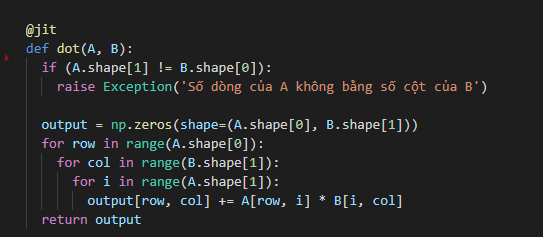


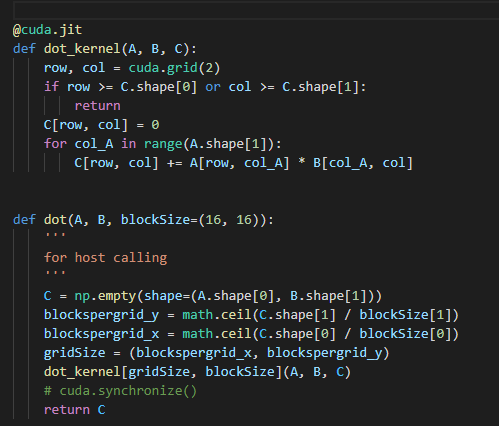

Việc module hoá các hàm kernel, cũng như giữa nguyên cấu trúc mô hình code sẽ giúp việc kiểm lỗi dể dàng hơn. Điều này cũng giúp đánh giá việc song song đó có giúp tăng tốc cho ứng dụng hay không.

## **Đánh giá**
Trong tuần đầu thực hiện song song hoá, các hàm đang được song song là các hàm hỗ trợ ít ảnh hưởng đến tốc độ thực thi nên tốc độ chưa được cải thiện nhiều. 
Và do gặp khó khăn trong việc khai báo các biến nằm trên device phục vụ cho bài toán scan nên vẫn ứng dụng chạy trên GPU vẫn chưa thể thực thi.

# **4. Cài đặt song song (trên GPU) + tối ưu hóa**

# **5. Nhìn lại quá trình làm đồ án**

# **6. Tài liệu tham khảo**

[1] https://victorzhou.com/blog/intro-to-cnns-part-1/

[2] https://victorzhou.com/blog/intro-to-cnns-part-2/

[3] https://www.kaggle.com/moltean/fruits